# Analysis of the CMAP overexpression data

In this notebook we analyze available gene expression data from the CMAP data set of U2OS cells in various overexpression conditions. The idea is to better understand whether or not the gene expression profiles cluster the overexpression conditions similar as observed in the structural and/or regulatory space.

---

## 0. Environmental setup

First, we setup the environment by loading required packages.

In [1]:
import pandas as pd
import numpy as np
from venn import venn
import matplotlib.pyplot as plt
from cmapPy.pandasGEXpress.parse import parse
import random
import umap
import seaborn as sns
from scipy.cluster import hierarchy as hc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
import sys
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer
from collections import Counter

sys.path.append("../../..")
from src.utils.notebooks.ppi.embedding import plot_tsne_embs
from imblearn.under_sampling import RandomUnderSampler

seed = 1234
np.random.seed(seed)
random.seed(1234)

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import ot
from tqdm.notebook import tqdm


def get_emd_for_embs(embs, label_col, metric="euclidean"):
    targets = np.unique(embs.loc[:, label_col])
    n_targets = len(targets)
    wd_mtx = np.infty * np.ones((n_targets, n_targets))
    for i in tqdm(range(n_targets), desc="Compute EMD"):
        source = targets[i]
        xs = np.array(embs.loc[embs.loc[:, label_col] == source]._get_numeric_data())
        ns = len(xs)
        ps = np.ones((ns,)) / ns
        for j in range(i, n_targets):
            target = targets[j]
            if source == target:
                wd_st = 0
            else:
                xt = np.array(
                    embs.loc[embs.loc[:, label_col] == target]._get_numeric_data()
                )
                nt = len(xt)
                pt = np.ones((nt,)) / nt
                m = ot.dist(xs, xt, metric=metric)
                m = m / m.max()
                wd_st = ot.emd2(ps, pt, m, numItermax=1e9)
            wd_mtx[i, j] = wd_st
            wd_mtx[j, i] = wd_st
    wd_df = pd.DataFrame(wd_mtx, columns=list(targets), index=list(targets))
    return wd_df

<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we read in all the required data sets which include the CMAP data and corresponding metadata as well as a number of gene sets that we will look at later in order to compare the observed structure to our inferred structural and regualtory space.

In [3]:
sig_info = pd.read_csv("../../../data/gex/cmap/siginfo_beta.txt", sep="\t")
gene_info = pd.read_csv("../../../data/gex/cmap/geneinfo_beta.txt", sep="\t")
cell_info = pd.read_csv("../../../data/gex/cmap/cellinfo_beta.txt", sep="\t")
l5_oe_gex_data = parse(
    "../../../data/gex/cmap/level5_beta_trt_oe_n34171x12328.gctx"
).data_df.transpose()

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<IPython.core.display.Javascript object>

In [4]:
spec_results = pd.read_csv(
    "../../../data/other/specificity_results/specificity_screen_results_cv.csv",
    index_col=0,
)
reg_embs_clusters = pd.read_csv(
    "../../../data/ppi/embedding/node_embeddings_cv_1024_2gexrecon_1graph_recon_mask_loss_newnodeset_clusters.csv",
    index_col=0,
)
reg_embs = pd.read_csv(
    "../../../data/ppi/embedding/node_embeddings_cv_1024_2gexrecon_1graphrecon_mask_loss_newnodeset.csv",
    index_col=0,
)
struct_embs = pd.read_hdf(
    "../../../data/experiments/image_embeddings/specificity_target_emb_cv_strat/final_1024/fold_0/test_latents.h5"
)

label_dict = {
    "AKT1S1": 0,
    "ATF4": 1,
    "BAX": 2,
    "BCL2L11": 3,
    "BRAF": 4,
    "CASP8": 5,
    "CDC42": 6,
    "CDKN1A": 7,
    "CEBPA": 8,
    "CREB1": 9,
    "CXXC4": 10,
    "DIABLO": 11,
    "E2F1": 12,
    "ELK1": 13,
    "EMPTY": 14,
    "ERG": 15,
    "FGFR3": 16,
    "FOXO1": 17,
    "GLI1": 18,
    "HRAS": 19,
    "IRAK4": 20,
    "JUN": 21,
    "MAP2K3": 22,
    "MAP3K2": 23,
    "MAP3K5": 24,
    "MAP3K9": 25,
    "MAPK7": 26,
    "MOS": 27,
    "MYD88": 28,
    "PIK3R2": 29,
    "PRKACA": 30,
    "PRKCE": 31,
    "RAF1": 32,
    "RELB": 33,
    "RHOA": 34,
    "SMAD4": 35,
    "SMO": 36,
    "SRC": 37,
    "SREBF1": 38,
    "TRAF2": 39,
    "TSC2": 40,
    "WWTR1": 41,
}
label_dict = dict(zip(list(label_dict.values()), list(label_dict.keys())))
struct_embs.loc[:, "labels"] = np.array(struct_embs.labels.map(label_dict))
mean_struct_embs = struct_embs.groupby("labels").mean()

selected_targets = set(
    spec_results.loc[spec_results.selected == True].index
).intersection(reg_embs_clusters.index)

<IPython.core.display.Javascript object>

In [5]:
morph_profiles = pd.read_csv(
    "../../../data/images/metadata/nuclei_profiles_hoechst_cleaned.csv", index_col=0
)
morph_profiles = morph_profiles.drop(morph_profiles.filter(regex="_X").columns, axis=1)
morph_profiles = morph_profiles.drop(morph_profiles.filter(regex="_Y").columns, axis=1)
morph_profiles = morph_profiles.drop(columns=["ImageNumber"])
mean_morph_profiles = morph_profiles.groupby("labels").mean()
mean_morph_profiles = pd.DataFrame(
    StandardScaler().fit_transform(mean_morph_profiles),
    index=mean_morph_profiles.index,
    columns=mean_morph_profiles.columns,
)
# labels = np.array(morph_profiles.labels)
# morph_profiles = morph_profiles._get_numeric_data()
# morph_profiles = pd.DataFrame(
#     StandardScaler().fit_transform(morph_profiles),
#     index=morph_profiles.index,
#     columns=morph_profiles.columns,
# )
# morph_profiles["labels"] = labels

<IPython.core.display.Javascript object>

In [6]:
sampled_morph_profiles = morph_profiles.loc[
    morph_profiles.labels.isin(list(struct_embs.labels))
]
labels = np.array(sampled_morph_profiles.labels)
sampled_morph_profiles = sampled_morph_profiles._get_numeric_data()
sampled_morph_profiles = pd.DataFrame(
    StandardScaler().fit_transform(sampled_morph_profiles),
    index=sampled_morph_profiles.index,
    columns=sampled_morph_profiles.columns,
)
sampled_morph_profiles["labels"] = labels

ru = RandomUnderSampler(
    sampling_strategy=dict(Counter(struct_embs.labels)), random_state=1234
)
sample_idc, _ = ru.fit_resample(
    np.array(list(range(len(sampled_morph_profiles)))).reshape(-1, 1),
    list(sampled_morph_profiles.labels),
)
sampled_morph_profiles = sampled_morph_profiles.iloc[sample_idc.ravel()]

<IPython.core.display.Javascript object>

In [80]:
morph_emd = get_emd_for_embs(sampled_morph_profiles, label_col="labels")

Compute EMD:   0%|          | 0/42 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

Before we dive into the analysis we will quickly filter out any signatures that are not related to our selected ORF targets.

In [6]:
sig_info = sig_info.loc[
    (sig_info["project_code"] == "TA")
    & (sig_info["cell_iname"] == "U2OS")
    # & (sig_info["qc_pass"] == 1)
]
sig_info = sig_info.loc[sig_info["pert_type"].isin(["trt_oe"])]
sig_info = sig_info.loc[sig_info["cmap_name"].isin(list(selected_targets))]
sig_info.index = np.array(sig_info.sig_id)
sig_info.head(5)

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
TA.OE005_U2OS_72H:BRDN0000405896:1,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000405896,...,U2OS,A21,TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....,TA.OE005_U2OS_72H_X1_B15:A21|TA.OE005_U2OS_72H...,NaN,TA,CDKN1A,1,1.0,0.0
TA.OE005_U2OS_72H:BRDN0000464915:1,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000464915,...,U2OS,D21,TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....,TA.OE005_U2OS_72H_X1_B15:D21|TA.OE005_U2OS_72H...,NaN,TA,E2F1,1,1.0,0.0
TA.OE005_U2OS_72H:BRDN0000401266:1,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000401266,...,U2OS,E20,TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....,TA.OE005_U2OS_72H_X1_B15:E20|TA.OE005_U2OS_72H...,NaN,TA,JUN,1,1.0,0.0
TA.OE005_U2OS_72H:BRDN0000400124:1,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000400124,...,U2OS,G23,TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....,TA.OE005_U2OS_72H_X1_B15:G23|TA.OE005_U2OS_72H...,NaN,TA,TRAF2,1,1.0,0.0
TA.OE005_U2OS_72H:BRDN0000464972:1,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000464972,...,U2OS,P09,TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....,TA.OE005_U2OS_72H_X1_B15:P09|TA.OE005_U2OS_72H...,NaN,TA,CDC42,0,0.0,0.0


<IPython.core.display.Javascript object>

There are 61 signatures available corresponding for the 39 overexpression targets. Note that, only 28 of those 61 signatures are flagged for being of high quality which e.g. correlates with the number of cells surviving the overexpression conditions as predominantely conditions are flagged as of high quality for which a large number of cells were available in the imaging data i.e. survived the intervention.

In [7]:
gene_id_symbol_dict = dict(
    zip(gene_info.loc[:, "gene_id"].astype(str), gene_info.loc[:, "gene_symbol"])
)
l5_oe_gex_data = l5_oe_gex_data.rename(gene_id_symbol_dict, axis=1)

<IPython.core.display.Javascript object>

---

## 3. Exploratory analysis

### 3.1. Gene coverage

Next, we focus on the genes captured in the computed signatures. A we are interested how many of our genes in the inferred regualtory network are either directly measured (i.e. part of the L1000 genes) respectively how well are the remaining ones inferred.

Additionally we are interested in which of those categories our structural regulator genes fall.

In [8]:
l1000_genes = set(gene_info.loc[gene_info.feature_space == "landmark", "gene_symbol"])
best_inf_genes = set(
    gene_info.loc[gene_info.feature_space == "best inferred", "gene_symbol"]
)
inf_genes = set(gene_info.loc[gene_info.feature_space == "inferred", "gene_symbol"])
not_rep_genes = set(
    gene_info.loc[gene_info.feature_space == "not reported", "gene_symbol"]
)

<IPython.core.display.Javascript object>

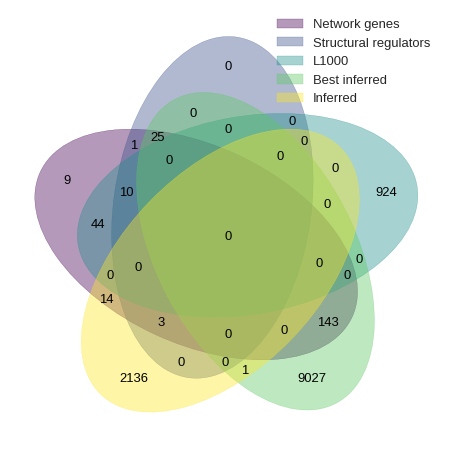

<IPython.core.display.Javascript object>

In [9]:
network_genes = set(reg_embs.index)
ax = venn(
    {
        "Network genes": network_genes,
        "Structural regulators": selected_targets,
        "L1000": l1000_genes,
        "Best inferred": best_inf_genes,
        "Inferred": inf_genes,
    },
    legend_loc="upper right",
)

We see that 10 genes of the network are note covered in the genes that form the gene signature among which is the structural regulator AKT1S1. 54/249 genes are part of the L1000 gene set (10 structural regulators) and additional 168/249 genes are in the set of those genes flagged as best inferred. Only 17 genes are flagged as only inferred.

The 10 genes that are not covered are shown below.

In [10]:
print(sorted(network_genes - set(gene_info.gene_symbol)))

['AKT1S1', 'CDCA2', 'HSPA1B', 'IGF2', 'KRT80', 'LOXL4', 'LZTS2', 'NEFL', 'NUF2', 'SPC24']


<IPython.core.display.Javascript object>

Those genes could theoretically be filtered out before inferring the gene-gene interactome which would allow us to use the gene signatures as node features when learning the corresponding embedding.

---

### 3.2 Clustering of the L1000 space

We will now cluster the overexpression conditions using the given gene signatures when subsetting those to the L1000 genes plus all covered structural regulators. For conditions for which there multiple signatures, we will take the mean of the given signatures as a consilodate signature.

In [11]:
l5_data = l5_oe_gex_data.loc[
    set(sig_info.sig_id),
    l1000_genes.union(network_genes.intersection(l5_oe_gex_data.columns)),
].copy()
l5_data.head()

rid,ACAA1,STAT5B,GPER1,MAP4K4,CDKN2A,SPAG7,P4HTM,PNKP,ERBB3,DIABLO,...,APBB2,SPDEF,MCUR1,METRN,STAMBP,VCAN,TSC2,TSPAN3,CCNA1,NISCH
cid,,,,,,,,,,,,,,,,,,,,,
TA.OE005_U2OS_72H:BRDN0000404857:1,-0.56520,1.93440,0.63235,0.64215,-0.94930,0.45480,0.05040,0.29835,-1.7340,0.95725,...,-0.03595,-0.67895,1.03395,0.46180,1.08425,0.08165,-0.51910,0.52515,3.22445,0.16940
TA.OE005_U2OS_72H:BRDN0000461613:1,0.41415,1.09595,0.48235,0.27410,0.82670,-0.59870,0.14430,-0.66300,-0.4529,1.13525,...,0.57455,0.63535,-0.21235,-0.07195,0.27450,-0.97320,0.06365,-0.37965,-0.29715,-1.03590
TA.OE005_U2OS_72H:BRDN0000459437:1,-0.50860,0.47845,-0.96665,0.44840,-0.23005,-1.16190,-1.20250,-0.30550,-0.1060,-1.00580,...,-0.16285,0.19830,0.02195,-0.28475,-0.44405,-0.34370,1.24495,-0.33595,-0.24565,-0.48765
TA.OE005_U2OS_72H:BRDN0000401266:1,-0.17180,-0.35445,-0.78835,-3.03295,-0.42020,-0.12215,-2.33670,5.08295,-0.5927,0.09010,...,0.41325,0.62385,-1.09295,-0.06775,1.08125,0.52745,0.02540,1.57915,1.48395,-0.21565
TA.OE005_U2OS_72H:BRDN0000464882:1,0.34795,1.00235,2.85240,0.24620,-1.03355,0.19495,-2.08995,0.37945,-0.9000,0.94430,...,-0.24980,-0.11250,-3.25165,1.99440,1.78705,-1.27885,-1.29325,1.26890,0.06750,-2.03330


<IPython.core.display.Javascript object>

#### tSNE visualization

After subsetting the data set accordingly we will now visualize the subset using a TSNE plot

In [12]:
mean_l5_data = l5_data.copy()
mean_l5_data["labels"] = np.array(sig_info.loc[mean_l5_data.index, "cmap_name"])
mean_l5_data = mean_l5_data.groupby("labels").mean()
mean_l5_data.head()

rid,ACAA1,STAT5B,GPER1,MAP4K4,CDKN2A,SPAG7,P4HTM,PNKP,ERBB3,DIABLO,...,APBB2,SPDEF,MCUR1,METRN,STAMBP,VCAN,TSC2,TSPAN3,CCNA1,NISCH
labels,,,,,,,,,,,,,,,,,,,,,
AKT1S1,0.777600,0.566825,-0.861275,-0.287375,-0.25150,-0.04110,0.27665,0.943625,-0.298800,0.057750,...,1.259100,-0.620900,-0.034525,1.22675,-0.057250,1.00345,0.410250,3.490500,0.399950,0.518700
ATF4,0.472100,-0.584425,2.792175,0.527625,0.21415,-2.09565,0.77185,-0.156150,-0.880275,-1.213000,...,0.883550,0.454175,-3.571650,-0.40660,-0.551375,0.53190,-0.571700,0.212700,0.359200,-1.797425
BAX,-0.252450,-0.193900,1.891200,-1.547000,1.92830,0.06630,0.58185,-0.393750,-0.101000,0.552150,...,2.913200,0.904300,-0.047000,-0.72880,-0.454850,0.37815,0.602700,-0.992300,0.714450,-2.705600
BCL2L11,0.737450,0.018050,-0.131200,-0.078650,0.21260,-0.19225,-0.87100,-0.844750,1.412650,-0.753850,...,-0.192900,1.080300,-0.590900,0.48625,-0.695200,-0.32825,-0.686500,-1.146300,-0.164450,-1.861750
BRAF,0.456167,-0.308200,-0.564867,1.325117,-0.26355,0.52030,-0.86740,0.771017,-0.860033,0.327917,...,1.389483,-0.472783,0.457883,0.39315,1.798850,-0.26475,-0.214767,0.745867,-0.165667,-1.051700


<IPython.core.display.Javascript object>

We will color each target in the tSNE plot by the corresponding regulatory cluster that we previously identified using KMeans clustering in the regulatory space.

In [13]:
l5_cluster_labels = np.array(reg_embs_clusters.loc[mean_l5_data.index]).ravel()

<IPython.core.display.Javascript object>

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


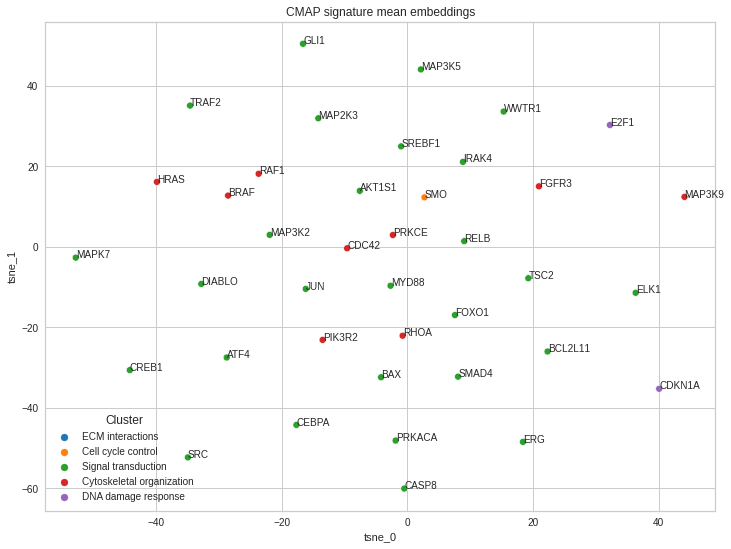

<IPython.core.display.Javascript object>

In [14]:
fig, ax = plt.subplots(figsize=[12, 9])
ax = plot_tsne_embs(
    mean_l5_data,
    ax=ax,
    perplexity=8,
    random_state=1234,
    hue=np.array(l5_cluster_labels).astype(str),
    hue_order=[
        "ECM interactions",
        "Cell cycle control",
        "Signal transduction",
        "Cytoskeletal organization",
        "DNA damage response",
    ],
    palette={
        "ECM interactions": "tab:blue",
        "Cell cycle control": "tab:orange",
        "Signal transduction": "tab:green",
        "Cytoskeletal organization": "tab:red",
        "DNA damage response": "tab:purple",
    },
)
ax.set_title("CMAP signature mean embeddings")
ax.legend(title="Cluster", loc="lower left")
# ax.set_xlim([-40, 50])
plt.show()

---

#### CMAP clustering

Next, we will cluster the CMAP signatures using Agglomerative clustering.
As we are particularly interested in the resemblance of the physical space structure, we will highligh observed clusters in the structural space.

In [7]:
struct_emd = get_emd_for_embs(struct_embs, label_col="labels")

Compute EMD:   0%|          | 0/42 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

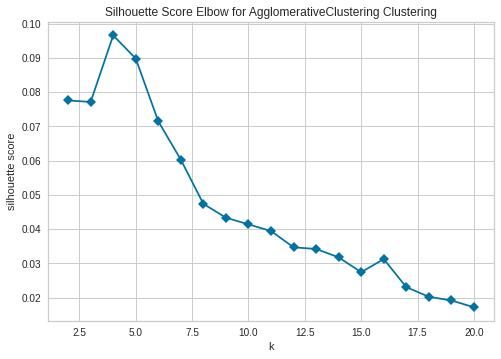

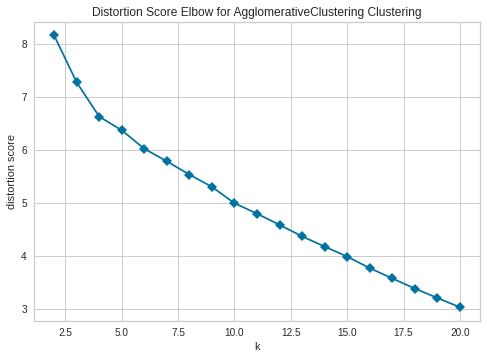

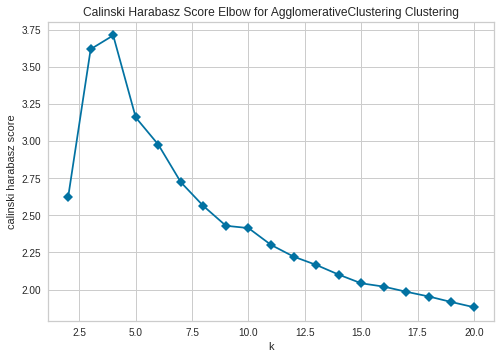

<IPython.core.display.Javascript object>

In [42]:
model = AgglomerativeClustering(affinity="precomputed", linkage="complete")
# model = KMeans(random_state=1234)
visualizer = KElbowVisualizer(
    model, k=20, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(struct_emd.loc[selected_targets, selected_targets])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=20, metric="distortion", timings=False, locate_elbow=False
)

visualizer.fit(struct_emd.loc[selected_targets, selected_targets])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=20, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(struct_emd.loc[selected_targets, selected_targets])
ax = visualizer.show()

In [39]:
# model = KMeans(n_clusters=3, random_state=1234)
model = AgglomerativeClustering(
    n_clusters=4, affinity="precomputed", linkage="complete"
)
struct_cluster_labels = model.fit_predict(
    struct_emd.loc[selected_targets, selected_targets]
)
struct_clusters = pd.DataFrame(
    struct_cluster_labels,
    index=struct_emd.loc[selected_targets, selected_targets].index,
    columns=["cluster"],
)
lut = dict(
    zip(
        list(np.unique(struct_cluster_labels)),
        [
            "tab:blue",
            "tab:red",
            "tab:green",
            "tab:brown",
            "tab:orange",
            "tab:pink",
            "tab:purple",
            "tab:gray",
            "tab:olive",
            "tab:cyan",
        ],
    )
)
struct_colors = pd.Series(
    struct_cluster_labels,
    index=struct_emd.loc[selected_targets, selected_targets].index,
).map(lut)

<IPython.core.display.Javascript object>

In [42]:
targets = list(struct_clusters.index)
#targets.remove("EMPTY")
print(targets)

['TRAF2', 'MAP3K5', 'BAX', 'SMAD4', 'RHOA', 'HRAS', 'GLI1', 'CASP8', 'CREB1', 'TSC2', 'MAPK7', 'BCL2L11', 'JUN', 'PRKACA', 'FOXO1', 'CEBPA', 'ERG', 'MAP3K9', 'FGFR3', 'RAF1', 'DIABLO', 'CDKN1A', 'SMO', 'SRC', 'PRKCE', 'AKT1S1', 'PIK3R2', 'WWTR1', 'ATF4', 'BRAF', 'MYD88', 'MAP2K3', 'E2F1', 'ELK1', 'RELB', 'CDC42', 'MAP3K2', 'SREBF1', 'IRAK4']


<IPython.core.display.Javascript object>

In [43]:
for cluster in np.unique(struct_clusters):
    print(cluster)
    print(list(struct_clusters.loc[struct_clusters.cluster == cluster].index))

0
['HRAS', 'CASP8', 'BCL2L11', 'CDKN1A']
1
['RHOA', 'GLI1', 'PRKACA', 'FOXO1', 'MAP3K9', 'RAF1', 'DIABLO', 'SMO', 'PRKCE', 'AKT1S1', 'BRAF', 'MYD88', 'MAP2K3', 'RELB', 'CDC42', 'MAP3K2', 'SREBF1']
2
['TRAF2', 'MAP3K5', 'BAX', 'SMAD4', 'CREB1', 'TSC2', 'MAPK7', 'FGFR3', 'SRC', 'PIK3R2', 'WWTR1', 'ATF4', 'ELK1', 'IRAK4']
3
['JUN', 'CEBPA', 'ERG', 'E2F1']


<IPython.core.display.Javascript object>

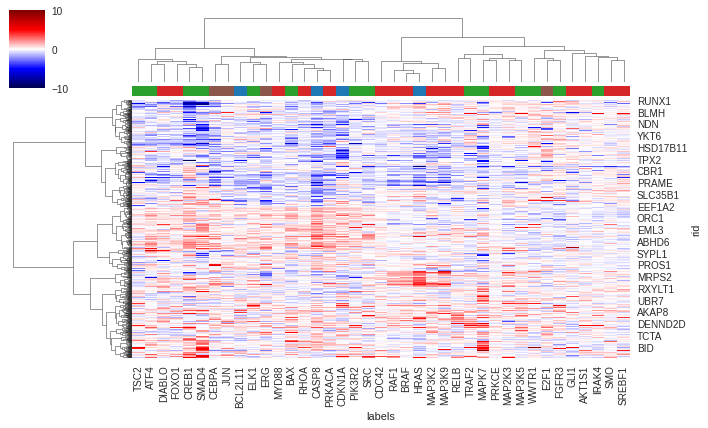

<IPython.core.display.Javascript object>

In [44]:
ax = sns.clustermap(
    mean_l5_data.transpose(),
    figsize=[10, 6],
    metric="cosine",
    cmap="seismic",
    method="ward",
    col_colors=np.array(struct_colors.loc[mean_l5_data.index]),
)
plt.show()

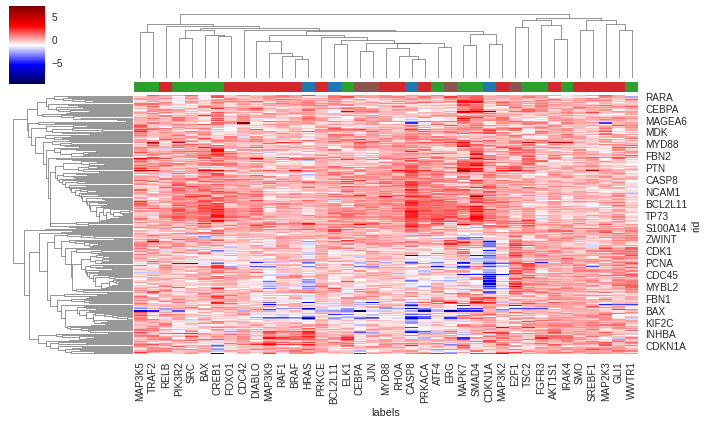

<IPython.core.display.Javascript object>

In [45]:
ax = sns.clustermap(
    mean_l5_data.transpose().loc[set(mean_l5_data.columns).intersection(network_genes)],
    figsize=[10, 6],
    metric="cosine",
    cmap="seismic",
    method="average",
    col_colors=np.array(struct_colors.loc[mean_l5_data.index]),
)
plt.show()

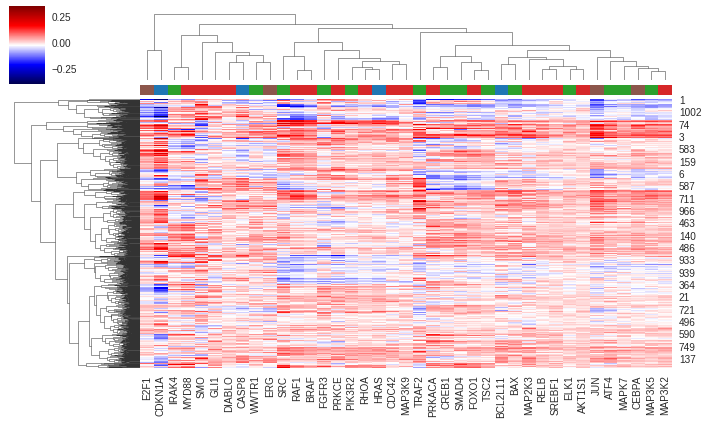

<IPython.core.display.Javascript object>

In [46]:
ax = sns.clustermap(
    reg_embs.loc[selected_targets].transpose(),
    figsize=[10, 6],
    metric="euclidean",
    cmap="seismic",
    method="complete",
    col_colors=np.array(struct_colors.loc[reg_embs.loc[selected_targets].index]),
)
plt.show()

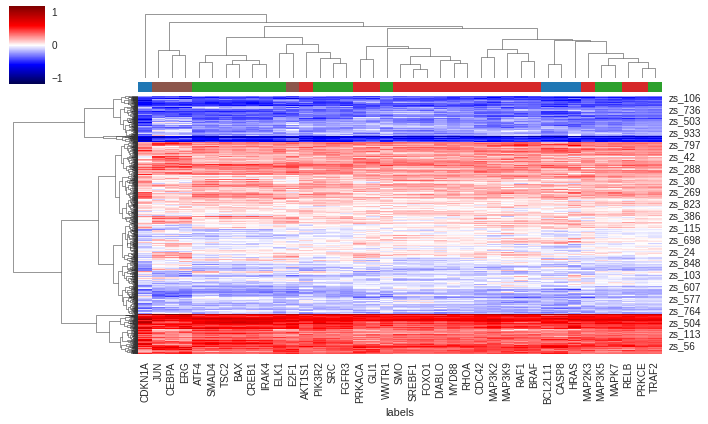

<IPython.core.display.Javascript object>

In [83]:
ax = sns.clustermap(
    mean_struct_embs.loc[selected_targets].transpose(),
    figsize=[10, 6],
    metric="euclidean",
    cmap="seismic",
    method="complete",
    col_colors=np.array(
        struct_colors.loc[mean_struct_embs.loc[selected_targets].index]
    ),
)
plt.show()

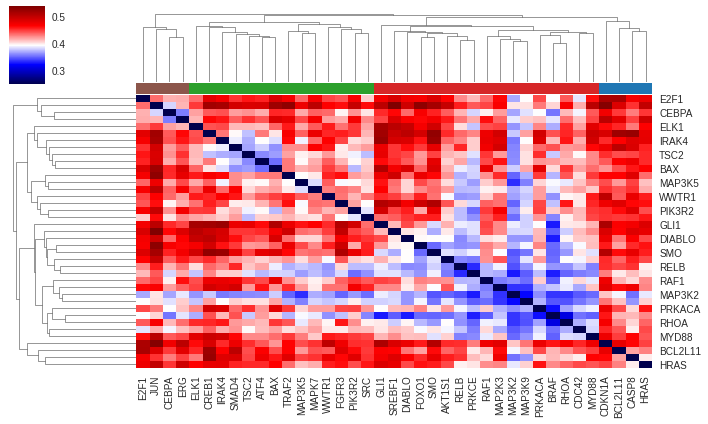

<IPython.core.display.Javascript object>

In [78]:
from scipy.spatial.distance import squareform

linkage = hc.linkage(
    squareform(struct_emd.loc[selected_targets, selected_targets]), method="complete"
)
ax = sns.clustermap(
    struct_emd.loc[selected_targets, selected_targets],
    row_linkage=linkage,
    col_linkage=linkage,
    figsize=[10, 6],
    cmap="seismic",
    vmin=0.25,
    col_colors=np.array(
        struct_colors.loc[struct_emd.loc[selected_targets, selected_targets].index]
    ),
)
plt.show()

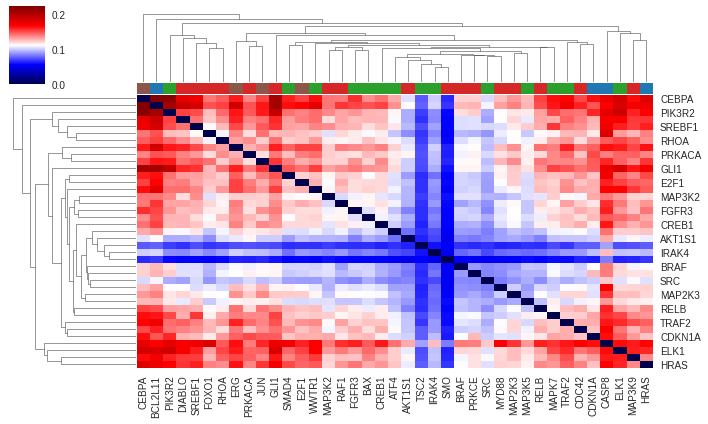

<IPython.core.display.Javascript object>

In [81]:
from scipy.spatial.distance import squareform

linkage = hc.linkage(
    squareform(morph_emd.loc[selected_targets, selected_targets]), method="complete"
)
ax = sns.clustermap(
    morph_emd.loc[selected_targets, selected_targets],
    row_linkage=linkage,
    col_linkage=linkage,
    figsize=[10, 6],
    cmap="seismic",
    col_colors=np.array(
        struct_colors.loc[morph_emd.loc[selected_targets, selected_targets].index]
    ),
)
plt.show()